# Задание:
1. Выбрать тематику научных публикаций, любую область знаний, например, machine learning или artificial intelligence. 
2. Скачать с https://arxiv.org/ данные о научных публикациях по выбранной тематике. Выгрузить названия, авторов и аннотации статей. Скачивать через api https://info.arxiv.org/help/api/user-manual.html. Не менее 250 публикаций. 
3. Выделить ключевые слова по каждой публикации (используйте названия и аннотации). 
4. Построить связи между ключевыми словами на основе их принадлежности публикациям с использованием библиотеки https://networkx.org/ (как альтернативный вариант можно посмотреть https://graph-tool.skewed.de/static/doc/index.html, https://cosmograph.app/docs/cosmograph/Cosmograph%20Python/configuration/)
5. Определить кластеры ключевых слов на графе. Оценить качество кластеризации (например, по модулярности). Интерпретировать результат.
6. Найти ключевые слова с наибольшими значениями центральности в выбранной тематике (например, degree centrality, betweenness centrality, eigenvector centrality, closeness centrality). Интерпретировать результаты.
7. Построить граф публикаций: если ключевое слово является тегом для двух публикаций, значит, между ними связь есть. Чем больше общих ключевых слов, тем сильнее связь (выше вес ребра). Реализовать поиск наиболее близких к заданной пользователем публикаций на графе.
# Критерии оценки:
- Сбор данных и выделение ключевых слов (пункты 1-2). Оценивается качество построения визуализаций, полнота и логика описания данных в отчете. (10 баллов)
- Построение и анализ графа ключевых слов. Оценивается полнота проведенного анализа, корректность реализации и интерпретация результатов. (12 баллов)
- Поиск по графу публикаций. Оценивается подход к поиску и корректность его реализации, полнота и логика описания решения в отчете. (8 баллов)


---
### 0. Импорты, скачивания

In [77]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129
%pip install requests feedparser pandas pdfplumber requests_cache diskcache yake networkx matplotlib scipy seaborn textblob stanza wordcloud cosmograph ipympl python-louvain scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu129
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [78]:
from urllib.parse import urlencode
import diskcache
import requests
import feedparser
import re
import pandas as pd
import pdfplumber
import io
import requests_cache
import logging as logging_main
from typing import Optional, TypedDict
import functools
import yake
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import seaborn as sns
import stanza
import nltk
from nltk.corpus import stopwords
from torch.cuda import get_device_name, is_available
from wordcloud import WordCloud
from cosmograph import cosmo
import community as community_louvain
from sklearn.cluster import SpectralClustering, DBSCAN
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


logging = logging_main.getLogger("lab-1")
logging.setLevel(logging_main.INFO)

requests_cache.install_cache("arxiv_cache", expire_after=None)
disk_cache = diskcache.Cache("pdf_cache_dir")

logging.info(get_device_name(0))
stanza.download('en')
nlp = stanza.Pipeline('en', use_gpu=is_available())

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

wordcloud = WordCloud(background_color='white', max_words=50)


def cache(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        key = (func.__name__, args, frozenset(kwargs.items()))
        if key in disk_cache:
            logging.info(f"Cache hit: {key}")
            return disk_cache[key]
        result = func(*args, **kwargs)
        disk_cache[key] = result
        return result
    return wrapper

2025-09-23 15:05:23 INFO: Downloaded file to C:\Users\HuTao1Love\stanza_resources\resources.json
2025-09-23 15:05:23 INFO: Downloading default packages for language: en (English) ...
2025-09-23 15:05:23 INFO: File exists: C:\Users\HuTao1Love\stanza_resources\en\default.zip
2025-09-23 15:05:25 INFO: Finished downloading models and saved to C:\Users\HuTao1Love\stanza_resources
2025-09-23 15:05:25 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-09-23 15:05:25 INFO: Downloaded file to C:\Users\HuTao1Love\stanza_resources\resources.json
2025-09-23 15:05:26 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2025-09-23 15:05:26 INFO: Using device: cuda
2025-09-23 15:05:26 INFO: Loading: tokenize
2025-09-23 15:05:26 INFO: Loading: mwt
2025-09-23 15:05:26 INFO: Loading: pos
2025-09-23 15:05:27 INFO: Loading: lemma
2025-09-23 15:05:28 INFO: Loading: constituency
2025-09-23 15:05:28 INFO: Loading: depparse
2025-09-23 15:05:28 INFO: Loading: sentiment
2025-09-23 15:05:28 INFO: Loadin

---
### 1. Выбрать тематику научных публикаций, любую область знаний, например, machine learning или artificial intelligence. 

In [79]:
# Config
BASE_URL = "https://export.arxiv.org/api/query"
CATEGORY = "cs.FL"  # Formal Languages and Automata Theory
RESULTS_COUNT = 250

---
### 2. Скачать с https://arxiv.org/ данные о научных публикациях по выбранной тематике. Выгрузить названия, авторов и аннотации статей. Скачивать через api https://info.arxiv.org/help/api/user-manual.html. Не менее 250 публикаций.

In [80]:
class Publication(TypedDict):
    title: str
    authors: list[str]
    summary: str
    keywords: Optional[list[str]]
    url: str


@cache
def fetch_pdf_keywords(url: str) -> list[str] | None:
    try:
        response = requests.get(url, timeout=(5, 60))
        response.raise_for_status()

        logging.info(f"Fetch {url}")

        with pdfplumber.open(io.BytesIO(response.content)) as pdf:
            text = "\n".join(page.extract_text() or "" for page in pdf.pages)

            keywords_match = re.search(
                r'(?i)(?:keywords?|KEYWORDS?):\s*([^\n]+)',
                text,
                re.IGNORECASE | re.DOTALL
            )

        return [kw.strip() for kw in keywords_match.group(1).split(',')] if keywords_match else None
    except Exception as e:
        logging.error(e)
        return None



def fetch_arxiv(category: str, results_count: int) -> list[Publication]:
    args = {
        "search_query": f"cat:{category}",
        "sortBy": "submittedDate",
        "sortOrder": "descending",
        "max_results": results_count
    }

    response = requests.get(f"{BASE_URL}?{urlencode(args)}")
    response.raise_for_status()

    feed = feedparser.parse(response.text)

    # not parallel because there is SIGSEGV either :D
    return [
        Publication(
            title=entry.title,
            authors=[author.name for author in entry.authors],
            summary=entry.summary,
            keywords=fetch_pdf_keywords(entry.id.replace("abs", "pdf")),
            url=entry.id.replace('abs', 'pdf'),
        )
        for entry in feed.entries
    ]

papers = fetch_arxiv(CATEGORY, RESULTS_COUNT)
papers

[{'title': 'Weighted Automata for Exact Inference in Discrete Probabilistic Programs',
  'authors': ['Dominik Geißler', 'Tobias Winkler'],
  'summary': 'In probabilistic programming, the inference problem asks to determine a\nprogram\'s posterior distribution conditioned on its "observe" instructions.\nInference is challenging, especially when exact rather than approximate results\nare required. Inspired by recent work on probability generating functions\n(PGFs), we propose encoding distributions on $\\mathbb{N}^k$ as weighted\nautomata over a commutative alphabet with $k$ symbols. Based on this, we map\nthe semantics of various imperative programming statements to\nautomata-theoretic constructions. For a rich class of programs, this results in\nan effective translation from prior to posterior distribution, both encoded as\nautomata. We prove that our approach is sound with respect to a standard\noperational program semantics.',
  'keywords': ['Weighted Automata · Probabilistic Program

In [81]:
print(len(papers))
df = pd.DataFrame(papers)
print(df.isnull().sum())
df.sample(10, random_state=52)

250
title         0
authors       0
summary       0
keywords    194
url           0
dtype: int64


,title,authors,summary,keywords,url
19,Identifiability and minimality bounds of quant...,"[Paul M. Riechers, Thomas J. Elliott]","To make sense of the world around us, we devel...",None,http://arxiv.org/pdf/2509.03004v1
144,The CAISAR Platform: Extending the Reach of Ma...,"[Michele Alberti, François Bobot, Julien Girar...",The formal specification and verification of m...,"[Formal verification, Machine learning]",http://arxiv.org/pdf/2506.12084v1
27,Computational Exploration of Finite Semigroupoids,"[Attila Egri-Nagy, Chrystopher L. Nehaniv]",Recent algorithmic advances in algebraic autom...,"[n, meaning]",http://arxiv.org/pdf/2509.00837v1
52,Box-Reachability in Vector Addition Systems,"[Shaull Almagor, Itay Hasson, Michał Pilipczuk...",We consider a variant of reachability in Vecto...,None,http://arxiv.org/pdf/2508.12853v1
225,Exploring Inevitable Waypoints for Unsolvabili...,"[Mir Md Sajid Sarwar, Rajarshi Ray]",Explaining unsolvability of planning problems ...,None,http://arxiv.org/pdf/2504.15668v1
203,Active Learning of Upward-Closed Sets of Words,[Quentin Aristote],We give a new proof of a result from well quas...,None,http://arxiv.org/pdf/2504.21429v2
26,Controller synthesis method for multi-agent sy...,"[Ruohan Huang, Zining Cao]",Controller synthesis is a theoretical approach...,None,http://arxiv.org/pdf/2509.00870v1
168,Automata Learning of Preferences over Temporal...,"[Hazhar Rahmani, Jie Fu]",Many preference elicitation algorithms conside...,[Automatalearning;Temporallogicinference;Prefe...,http://arxiv.org/pdf/2505.18030v1
91,Hyper pattern matching,"[Masaki Waga, Étienne André]","In runtime verification, pattern matching, whi...",[runtimeverification·hyperproperties·patternma...,http://arxiv.org/pdf/2507.12102v1
114,On the Reachability Problem for Two-Dimensiona...,"[Clotilde Bizière, Thibault Hilaire, Jérôme Le...","Vectors addition systems with states (VASS), o...",None,http://arxiv.org/pdf/2506.22561v1


---
### 3. Выделить ключевые слова по каждой публикации (используйте названия и аннотации).

In [82]:
yake_extractor = yake.KeywordExtractor(lan="en", n=4, dedupLim=0.85, top=20)


def update_keywords(row):
    extract_keywords = lambda text: [kw[0] for kw in yake_extractor.extract_keywords(text.lower())]

    existing_keywords = set(row["keywords"]) if isinstance(row["keywords"], list) else set()
    new_keywords = set(extract_keywords(row["title"] + " " + row["summary"]))

    updated_keywords = list(existing_keywords | new_keywords)
    return updated_keywords


df["keywords"] = df.apply(update_keywords, axis=1)
print(df.iloc[1].keywords)
df[['title', 'keywords']].head(5)

['deterministically recognizable weighted', 'languages over commutative', 'cancellative scalar algebras due', 'tree languages', 'recognizable weighted tree languages', 'tree languages over commutative', 'syntactic vector spaces', 'languages over commutative semifields', 'cancellative scalar algebras', 'respective m-syntactic scalar algebras', 'scalar algebras due', 'well-known characterization of recognizable', 'bottom-up deterministically recognizable weighted', 'weighted tree languages', 'recognizable weighted', 'weighted tree', 'tree languages over fields', 'recognizable weighted tree', 'finite-dimensionality of syntactic vector', 'deterministically recognizable weighted tree']


,title,keywords
0,Weighted Automata for Exact Inference in Discr...,"[inference, weighted automata, posterior distr..."
1,Characterization of deterministically recogniz...,"[deterministically recognizable weighted, lang..."
2,Active Learning of Symbolic Mealy Automata,"[symbolic mealy automata, input characters, al..."
3,On the Complexity of the Secret Protection Pro...,"[minimum-cost policy ensuring, state includes ..."
4,The Complexity of Generalized HyperLTL with St...,"[generalized hyperltl with stuttering, general..."


In [83]:
@cache
def lemmatize_keywords_stanza(keywords):
    lemmatized_phrases = []

    for phrase in keywords:
        doc = nlp(phrase)
        lemmatized_words = [word.lemma for word in doc.iter_words()]
        lemmatized_phrases.append(" ".join(lemmatized_words))

    return lemmatized_phrases


df['lemmatized_keywords'] = df['keywords'].apply(lambda row: lemmatize_keywords_stanza(row))
print(*df[['keywords', 'lemmatized_keywords']].iloc[1].values, sep='\n')
df.sample(5, random_state=52)

['deterministically recognizable weighted', 'languages over commutative', 'cancellative scalar algebras due', 'tree languages', 'recognizable weighted tree languages', 'tree languages over commutative', 'syntactic vector spaces', 'languages over commutative semifields', 'cancellative scalar algebras', 'respective m-syntactic scalar algebras', 'scalar algebras due', 'well-known characterization of recognizable', 'bottom-up deterministically recognizable weighted', 'weighted tree languages', 'recognizable weighted', 'weighted tree', 'tree languages over fields', 'recognizable weighted tree', 'finite-dimensionality of syntactic vector', 'deterministically recognizable weighted tree']
['deterministically recognizable weight', 'language over commutative', 'cancellative scalar algebra due', 'tree language', 'recognizable weight tree language', 'tree language over commutative', 'syntactic vector space', 'language over commutative semifield', 'cancellative scalar algebra', 'respective m-syntac

,title,authors,summary,keywords,url,lemmatized_keywords
19,Identifiability and minimality bounds of quant...,"[Paul M. Riechers, Thomas J. Elliott]","To make sense of the world around us, we devel...","[minimality bounds, generate classical stochas...",http://arxiv.org/pdf/2509.03004v1,"[minimality bound, generate classical stochast..."
144,The CAISAR Platform: Extending the Reach of Ma...,"[Michele Alberti, François Bobot, Julien Girar...",The formal specification and verification of m...,"[formal specification and verification, verifi...",http://arxiv.org/pdf/2506.12084v1,"[formal specification and verification, verifi..."
27,Computational Exploration of Finite Semigroupoids,"[Attila Egri-Nagy, Chrystopher L. Nehaniv]",Recent algorithmic advances in algebraic autom...,"[semigroupoids recent algorithmic, computation...",http://arxiv.org/pdf/2509.00837v1,"[semigroupoid recent algorithmic, computationa..."
52,Box-Reachability in Vector Addition Systems,"[Shaull Almagor, Itay Hasson, Michał Pilipczuk...",We consider a variant of reachability in Vecto...,"[standard reachability set, vector addition, b...",http://arxiv.org/pdf/2508.12853v1,"[standard reachability set, vector addition, b..."
225,Exploring Inevitable Waypoints for Unsolvabili...,"[Mir Md Sajid Sarwar, Rajarshi Ray]",Explaining unsolvability of planning problems ...,"[significant research, planning problems expla...",http://arxiv.org/pdf/2504.15668v1,"[significant research, planning problem explai..."


In [84]:
def clean_keywords(keywords):
    cleaned_keywords = [
        " ".join([word for word in phrase.split() if word not in stop_words])
        for phrase in keywords
    ]

    return [i for i in cleaned_keywords if i]


df['cleaned_keywords'] = df['lemmatized_keywords'].apply(clean_keywords)
print(*df.iloc[1].cleaned_keywords, sep='\n')
df.sample(5, random_state=52)

deterministically recognizable weight
language commutative
cancellative scalar algebra due
tree language
recognizable weight tree language
tree language commutative
syntactic vector space
language commutative semifield
cancellative scalar algebra
respective m-syntactic scalar algebra
scalar algebra due
well - know characterization recognizable
bottom - deterministically recognizable weight
weight tree language
recognizable weight
weight tree
tree language field
recognizable weight tree
finite - dimensionality syntactic vector
deterministically recognizable weight tree


,title,authors,summary,keywords,url,lemmatized_keywords,cleaned_keywords
19,Identifiability and minimality bounds of quant...,"[Paul M. Riechers, Thomas J. Elliott]","To make sense of the world around us, we devel...","[minimality bounds, generate classical stochas...",http://arxiv.org/pdf/2509.03004v1,"[minimality bound, generate classical stochast...","[minimality bound, generate classical stochast..."
144,The CAISAR Platform: Extending the Reach of Ma...,"[Michele Alberti, François Bobot, Julien Girar...",The formal specification and verification of m...,"[formal specification and verification, verifi...",http://arxiv.org/pdf/2506.12084v1,"[formal specification and verification, verifi...","[formal specification verification, verificati..."
27,Computational Exploration of Finite Semigroupoids,"[Attila Egri-Nagy, Chrystopher L. Nehaniv]",Recent algorithmic advances in algebraic autom...,"[semigroupoids recent algorithmic, computation...",http://arxiv.org/pdf/2509.00837v1,"[semigroupoid recent algorithmic, computationa...","[semigroupoid recent algorithmic, computationa..."
52,Box-Reachability in Vector Addition Systems,"[Shaull Almagor, Itay Hasson, Michał Pilipczuk...",We consider a variant of reachability in Vecto...,"[standard reachability set, vector addition, b...",http://arxiv.org/pdf/2508.12853v1,"[standard reachability set, vector addition, b...","[standard reachability set, vector addition, b..."
225,Exploring Inevitable Waypoints for Unsolvabili...,"[Mir Md Sajid Sarwar, Rajarshi Ray]",Explaining unsolvability of planning problems ...,"[significant research, planning problems expla...",http://arxiv.org/pdf/2504.15668v1,"[significant research, planning problem explai...","[significant research, planning problem explai..."


In [85]:
df.describe()

,title,authors,summary,keywords,url,lemmatized_keywords,cleaned_keywords
count,250,250,250,250,250,250,250
unique,250,246,250,250,250,250,250
top,Weighted Automata for Exact Inference in Discr...,"[Bruno Guillon, Luca Prigioniero, Javad Taheri]","In probabilistic programming, the inference pr...","[inference, weighted automata, posterior distr...",http://arxiv.org/pdf/2509.15074v1,"[inference, weight automata, posterior distrib...","[inference, weight automata, posterior distrib..."
freq,1,2,1,1,1,1,1


C:\Users\HuTao1Love\AppData\Local\Temp\ipykernel_14908\1136677713.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_keywords.values()), y=list(top_keywords.keys()), palette="viridis")


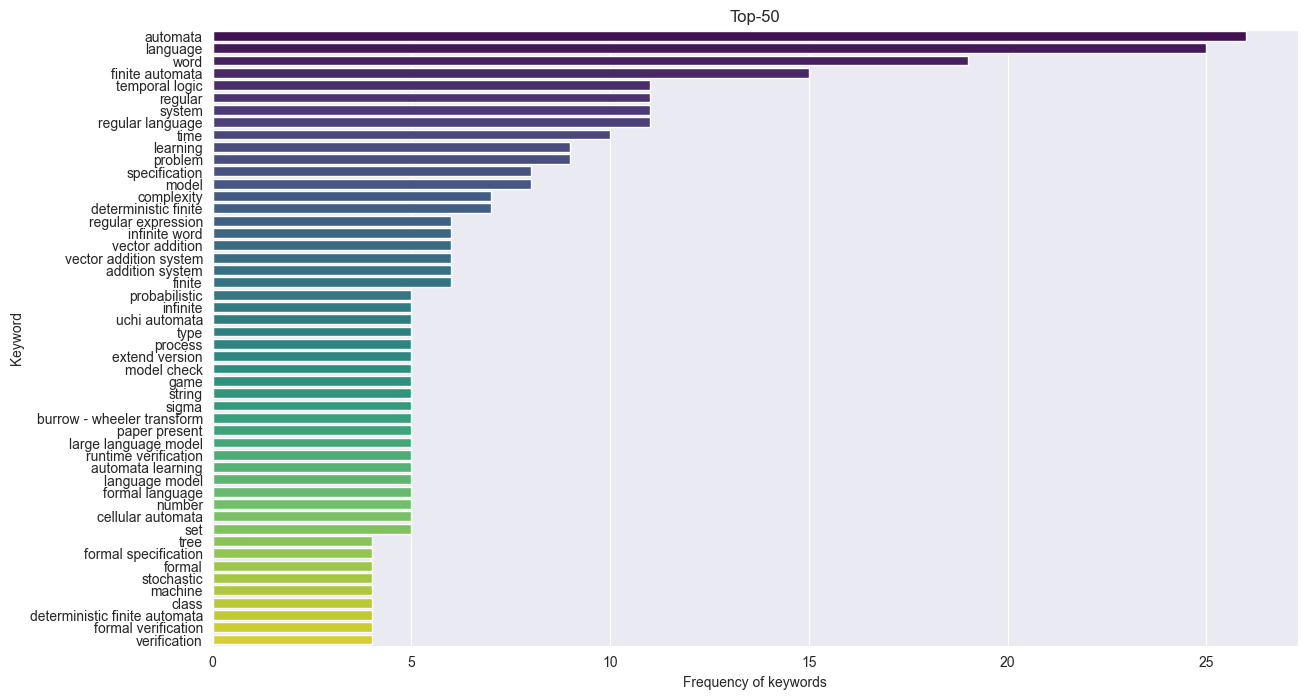

In [86]:
all_keywords = [word for keywords in df['cleaned_keywords'] for word in keywords]
keyword_freq = Counter(all_keywords)

most_common_keywords = keyword_freq.most_common(50)
top_keywords = dict(most_common_keywords)
plt.figure(figsize=(14, 8))
sns.barplot(x=list(top_keywords.values()), y=list(top_keywords.keys()), palette="viridis")
plt.xlabel('Frequency of keywords')
plt.ylabel('Keyword')
plt.title('Top-50')
plt.show()

In [87]:
df.sample(10, random_state=52)

,title,authors,summary,keywords,url,lemmatized_keywords,cleaned_keywords
19,Identifiability and minimality bounds of quant...,"[Paul M. Riechers, Thomas J. Elliott]","To make sense of the world around us, we devel...","[minimality bounds, generate classical stochas...",http://arxiv.org/pdf/2509.03004v1,"[minimality bound, generate classical stochast...","[minimality bound, generate classical stochast..."
144,The CAISAR Platform: Extending the Reach of Ma...,"[Michele Alberti, François Bobot, Julien Girar...",The formal specification and verification of m...,"[formal specification and verification, verifi...",http://arxiv.org/pdf/2506.12084v1,"[formal specification and verification, verifi...","[formal specification verification, verificati..."
27,Computational Exploration of Finite Semigroupoids,"[Attila Egri-Nagy, Chrystopher L. Nehaniv]",Recent algorithmic advances in algebraic autom...,"[semigroupoids recent algorithmic, computation...",http://arxiv.org/pdf/2509.00837v1,"[semigroupoid recent algorithmic, computationa...","[semigroupoid recent algorithmic, computationa..."
52,Box-Reachability in Vector Addition Systems,"[Shaull Almagor, Itay Hasson, Michał Pilipczuk...",We consider a variant of reachability in Vecto...,"[standard reachability set, vector addition, b...",http://arxiv.org/pdf/2508.12853v1,"[standard reachability set, vector addition, b...","[standard reachability set, vector addition, b..."
225,Exploring Inevitable Waypoints for Unsolvabili...,"[Mir Md Sajid Sarwar, Rajarshi Ray]",Explaining unsolvability of planning problems ...,"[significant research, planning problems expla...",http://arxiv.org/pdf/2504.15668v1,"[significant research, planning problem explai...","[significant research, planning problem explai..."
203,Active Learning of Upward-Closed Sets of Words,[Quentin Aristote],We give a new proof of a result from well quas...,"[minimally adequate teacher, upwards-closed se...",http://arxiv.org/pdf/2504.21429v2,"[minimally adequate teacher, upwards - close s...","[minimally adequate teacher, upwards - close s..."
26,Controller synthesis method for multi-agent sy...,"[Ruohan Huang, Zining Cao]",Controller synthesis is a theoretical approach...,"[specification controller synthesis, control, ...",http://arxiv.org/pdf/2509.00870v1,"[specification controller synthesis, control, ...","[specification controller synthesis, control, ..."
168,Automata Learning of Preferences over Temporal...,"[Hazhar Rahmani, Jie Fu]",Many preference elicitation algorithms conside...,"[formulas from pairwise comparisons, logic for...",http://arxiv.org/pdf/2505.18030v1,"[formula from pairwise comparison, logic formu...","[formula pairwise comparison, logic formula it..."
91,Hyper pattern matching,"[Masaki Waga, Étienne André]","In runtime verification, pattern matching, whi...","[hyper pattern matching, matching in runtime v...",http://arxiv.org/pdf/2507.12102v1,"[hyper pattern matching, match in runtime veri...","[hyper pattern matching, match runtime verific..."
114,On the Reachability Problem for Two-Dimensiona...,"[Clotilde Bizière, Thibault Hilaire, Jérôme Le...","Vectors addition systems with states (VASS), o...","[studied formalisms, vectors addition systems,...",http://arxiv.org/pdf/2506.22561v1,"[study formalism, vector addition system, vass...","[study formalism, vector addition system, vass..."


---
### 4. Построить связи между ключевыми словами на основе их принадлежности публикациям с использованием библиотеки https://networkx.org/ (как альтернативный вариант можно посмотреть https://graph-tool.skewed.de/static/doc/index.html, https://cosmograph.app/docs/cosmograph/Cosmograph%20Python/configuration/)

In [88]:
keywords_list = [item for sublist in df['cleaned_keywords'] for item in sublist]
unique_keywords = list(set(keywords_list))

points = pd.DataFrame({
    'id': range(len(unique_keywords)),
    'label': unique_keywords,
    'value': [keywords_list.count(keyword) for keyword in unique_keywords],
    'category': ['General' for _ in unique_keywords]
})

points.sort_values(by='value', ascending=False)

,id,label,value,category
977,977,automata,26,General
3960,3960,language,25,General
1147,1147,word,19,General
3705,3705,finite automata,15,General
201,201,system,11,General
...,...,...,...,...
4514,4514,matrice,1,General
4515,4515,label,1,General
4516,4516,stay positive,1,General
4517,4517,lattice,1,General


In [89]:
links_list = []
for keywords in df['cleaned_keywords']:
    for pair in itertools.combinations(keywords, 2):
        keyword_1, keyword_2 = pair
        id_1 = points[points['label'] == keyword_1].id.values[0]
        id_2 = points[points['label'] == keyword_2].id.values[0]
        links_list.append({
            'source': id_1,
            'target': id_2,
            'value': 1.0,
        })

links = pd.DataFrame(links_list)
links.shape

(49812, 3)

In [90]:
widget = cosmo(
    points=points,
    links=links,
    point_id_by='id',
    link_source_by='source',
    link_target_by='target',
    point_color_by='category',
    point_include_columns=['value'],
    point_label_by='label',
    link_include_columns=['value'],
)

display(widget)

Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

In [91]:
filtered_points = points[points['value'] > 1]
filtered_points.sort_values(by='value', ascending=False)

,id,label,value,category
977,977,automata,26,General
3960,3960,language,25,General
1147,1147,word,19,General
3705,3705,finite automata,15,General
201,201,system,11,General
...,...,...,...,...
4005,4005,active learning,2,General
4012,4012,pattern matching,2,General
4017,4017,observe,2,General
4026,4026,finite automata translucent,2,General


In [92]:
links_list_1 = []
for keywords in df['cleaned_keywords']:
    for pair in itertools.combinations(keywords, 2):
        keyword_1, keyword_2 = pair

        if keyword_1 in filtered_points['label'].values and keyword_2 in filtered_points['label'].values:
            id_1 = filtered_points[filtered_points['label'] == keyword_1].id.values[0]
            id_2 = filtered_points[filtered_points['label'] == keyword_2].id.values[0]
            links_list_1.append({
                'source': id_1,
                'target': id_2,
                'value': 1.0,
            })

links_1 = pd.DataFrame(links_list_1)

widget = cosmo(
    points=filtered_points,
    links=links_1,
    point_id_by='id',
    link_source_by='source',
    link_target_by='target',
    point_color_by='category',
    point_include_columns=['value'],
    point_label_by='label',
    link_include_columns=['value'],
)

print(links_1.shape)
widget

(1823, 3)


Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

---
### 5. Определить кластеры ключевых слов на графе. Оценить качество кластеризации (например, по модулярности). Интерпретировать результат.

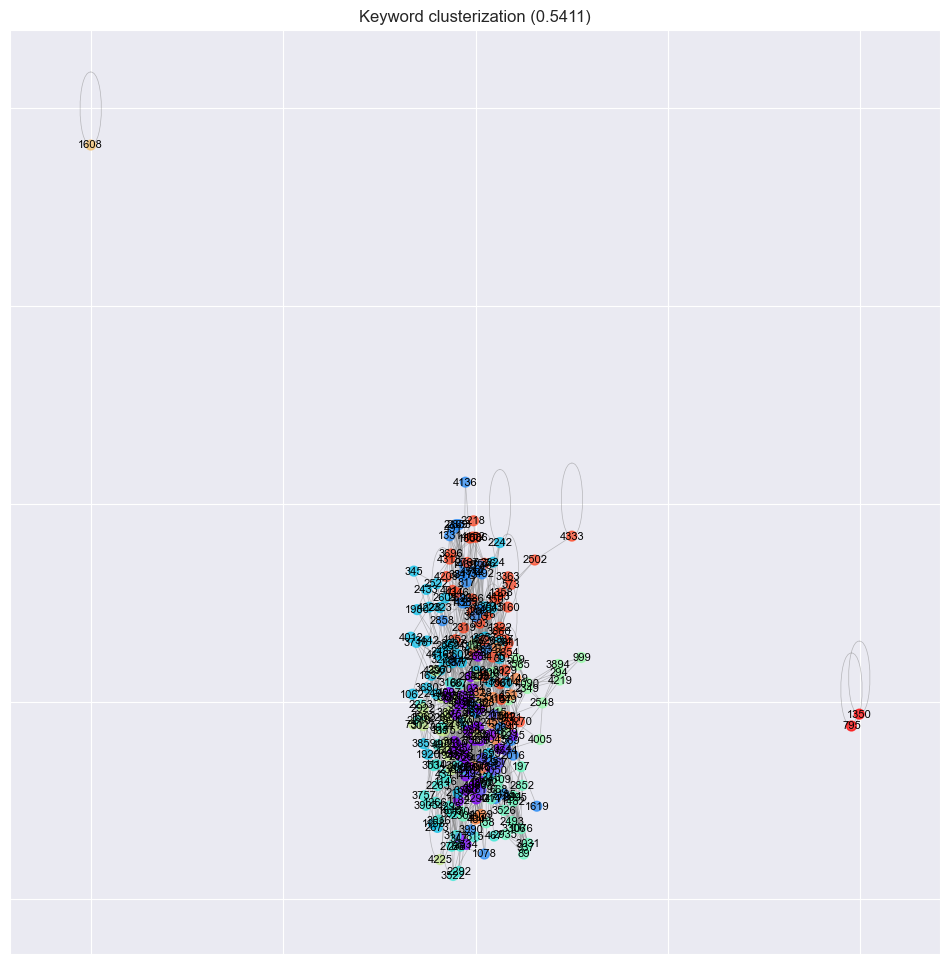

In [93]:
G = nx.Graph()

for _, row in filtered_points.iterrows():
    G.add_node(row['id'], label=row['label'], value=row['value'])

for _, row in links_1.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['value'])

G = G.subgraph([node for node in G.nodes() if G.degree(node) >= 2])

partition = community_louvain.best_partition(G)
modularity = community_louvain.modularity(partition, G)

node_colors = [partition[node] for node in G.nodes()]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')
plt.title(f"Keyword clusterization ({modularity:.4f})")
plt.show()

In [94]:
cluster_info = {}
for node, cluster in partition.items():
    cluster_info.setdefault(cluster, []).append(G.nodes[node]['label'])

filtered_cluster_info = {cluster: keywords for cluster, keywords in cluster_info.items() if len(keywords) > 1}

for cluster, keywords in sorted(filtered_cluster_info.items(), key=lambda item: item[0]):
    print(f"Cluster {cluster}: {', '.join(keywords)}")

Cluster 0: deterministic, polynomial time, tree language, finite state, tree, regular language, finite, automaton model, expression, family, regular tree language, automata, regular expression, dsa, finite word, automata define, alternate parity automata, number, language finite tree, grammar, language characterize, function, regular language finite, uchi automata, chain, infinite, parity, sigma, log, parity automata, introduce, first - order logic, omega, closure, language, regular, regular tree, alternate parity, burrow - wheeler transform, infinite word
Cluster 1: ldot, system, digit, set, decidable, rational, mathcal, mathbb
Cluster 2: molecular programming, transformer - base large language, programming language, language model, bwt, sequence, transformer, large language model, kleene algebra, modern language model, transition, constraint, transformer - base large, splicing, formalization, string, mathsf, transformer - base large language model, datum type, symbolic, decision proc

### Cluster 0
**Keywords:** deterministic, polynomial time, tree language, finite state, tree, regular language, finite, automaton model, expression, family, regular tree language, automata, regular expression, dsa, finite word, automata define, alternate parity automata, number, language finite tree, grammar, language characterize, function, regular language finite, uchi automata, chain, infinite, parity, sigma, log, parity automata, introduce, first-order logic, omega, closure, language, regular, regular tree, alternate parity, burrow-wheeler transform  
- Теория автоматов и формальных языков, с акцентом на **детерминированные модели, деревья, регулярные языки и сложности вычислений**. Кластер охватывает как фундаментальные термины, так и специфические конструкции вроде parity automata и Burrow-Wheeler Transform.

### Cluster 1
**Keywords:** ldot, system, digit, set, decidable, rational, mathcal, mathbb  
- Узкая математическая или формальная тематика, связанная с **решаемостью, множествами и числовыми/символьными системами**.

### Cluster 2
**Keywords:** molecular programming, transformer - base large language, programming language, language model, bwt, sequence, transformer, large language model, kleene algebra, modern language model, transition, constraint, splicing, formalization, string, llm, formal language, code, formal, symbolic, datum type, fundamental component  
- **Современные языковые модели и формальные методы**, включая трансформеры, LLM, молекулярное программирование и формальные языки. Кластер объединяет как практические технологии, так и теоретические конструкции.

### Cluster 3
**Keywords:** testing, controller synthesis, theorem prove, time, verification technique, runtime monitor, synthesis, game, label transition system, logic formula, temporal logic, signal temporal, formal verification, runtime verification, strategy, pattern matching  
- **Формальная верификация и синтез контроллеров**, включая временную логику, проверку моделей, стратегии и мониторинг выполнения систем. Практическая направленность на контроль и корректность сложных систем.

### Cluster 4
**Keywords:** dynamical system, cellular automata, context-free language, substitution, elementary cellular, word, binary word, critical, model-check problem, fix point, generalize abelian complexity, complexity, exponent, infinite word  
- **Динамические системы и автоматные модели**. Включает деревья, конечные состояния, сложность слов, клеточные автоматы и задачи проверки моделей.

### Cluster 5
**Keywords:** computer science, low complexity, addition, theoretical computer science, addition system, system state, vector addition system, coverability, Petri net, context-free, reachability problem, concurrent system  
- **Теоретическая информатика и формальные модели**, включая системы Аддитивных систем, сети Петри, достижимость и параллельные системы.

### Cluster 6
**Keywords:** computation, busy beaver, machine, formal language automata, high order, automata theory, turing machine, proof, active learning, store  
- **Классические вычислительные модели и теория алгоритмов**, включая машины Тьюринга, задачи Busy Beaver, обучение автоматов и теорию автоматов.

### Cluster 7
**Keywords:** nondeterministic finite automata, deterministic finite automata, universal finite-state machine, finite automaton, automaton, characterize regular language, finite-state machine, minimizer, framework  
- **Конечные автоматы и регулярные выражения**, с упором на детерминированные и недетерминированные модели, универсальные автоматы и методы минимизации.

### Cluster 9
**Keywords:** characterize, generate group, group, result, finitely generate, input word, type, monoid, infinite sequence, word problem, class, reactive synthesis, pushdown, input letter  
- **Теория групп и алгебраические структуры**, включая генерацию групп, задачи слов, моноиды и автоматные модели, а также синтез реактивных систем.

### Cluster 10
**Keywords:** quantum, active automata, automata learning algorithm, context-free grammar, regular model check, markov decision process, stochastic, pushdown automata, learning algorithm, model check, markov chain, probabilistic program  
- **Обучение автоматов и вероятностные модели**, включая активное обучение, стохастические процессы, MDP и проверки моделей.

### Cluster 11
**Keywords:** cap theorem, partition tolerance  
- **Распределённые системы**, принципы CAP, устойчивость к разбиению сети и согласованность данных.

In [95]:
filtered_points = points[points['label'].isin([keyword for cluster, keywords in filtered_cluster_info.items() if len(keywords) > 1 for keyword in keywords])]

links_list_2 = []
for keywords in df['cleaned_keywords']:
    for pair in itertools.combinations(keywords, 2):
        keyword_1, keyword_2 = pair

        if keyword_1 in filtered_points['label'].values and keyword_2 in filtered_points['label'].values:
            id_1 = filtered_points[filtered_points['label'] == keyword_1].id.values[0]
            id_2 = filtered_points[filtered_points['label'] == keyword_2].id.values[0]
            links_list_2.append({
                'source': id_1,
                'target': id_2,
                'value': 1.0,
            })

links_2 = pd.DataFrame(links_list_2)

widget = cosmo(
    points=filtered_points,
    links=links_2,
    point_id_by='id',
    link_source_by='source',
    link_target_by='target',
    point_color_by='category',
    point_include_columns=['value'],
    point_label_by='label',
    link_include_columns=['value'],
)

widget

Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

### SpectralClustering

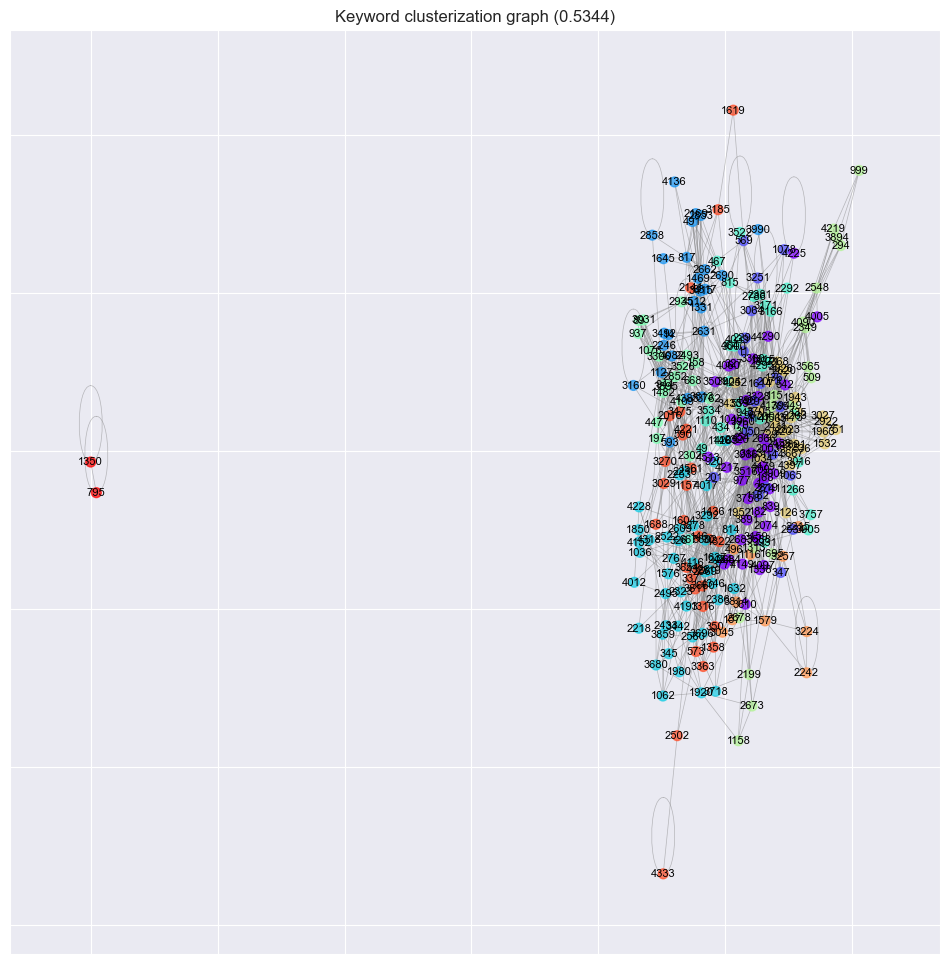

In [96]:
G = nx.Graph()

for _, row in filtered_points.iterrows():
    G.add_node(row['id'], label=row['label'], value=row['value'])

for _, row in links_2.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['value'])

G = G.subgraph([node for node in G.nodes() if G.degree(node) >= 2])

partition = community_louvain.best_partition(G)

modularity = community_louvain.modularity(partition, G)
node_colors = [partition[node] for node in G.nodes()]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')
plt.title(f"Keyword clusterization graph ({modularity:.4f})")
plt.show()

C:\Users\HuTao1Love\PycharmProjects\data-analysis\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


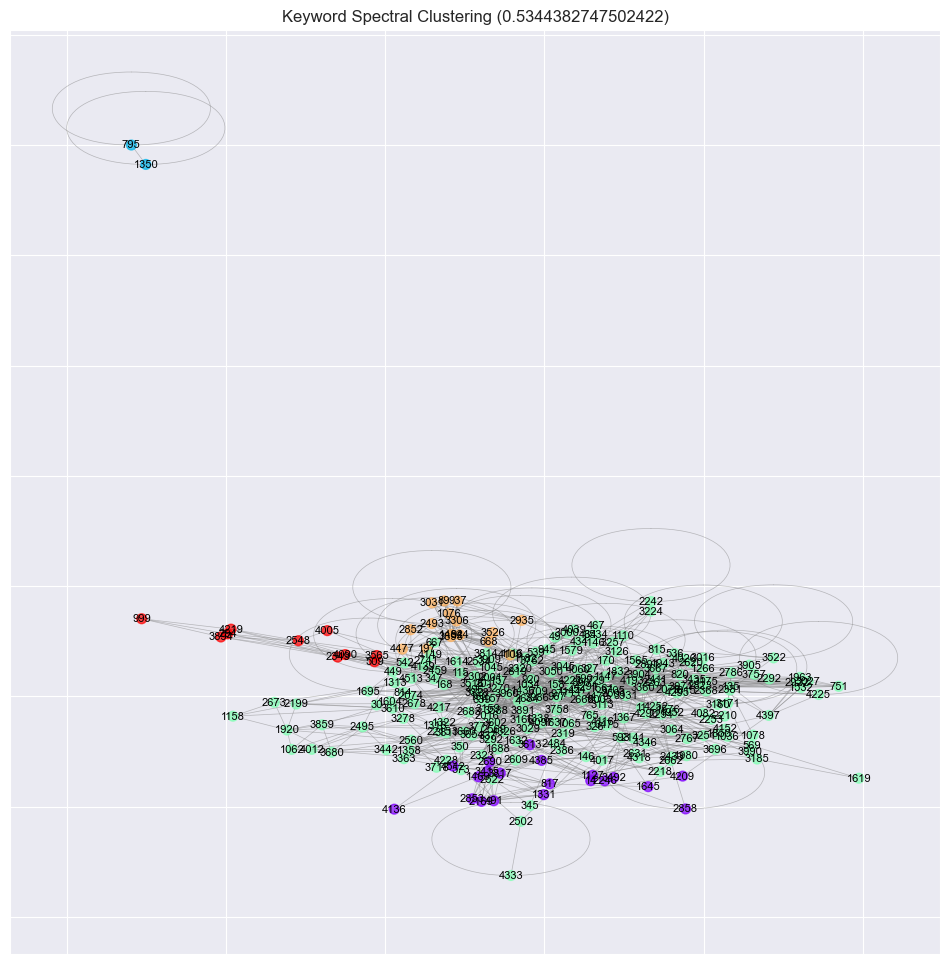

In [97]:
adjacency_matrix = nx.to_numpy_array(G)

clustering = SpectralClustering(5, affinity='precomputed', random_state=52)
labels = clustering.fit_predict(adjacency_matrix)

node_colors = labels
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')
plt.title(f"Keyword Spectral Clustering ({modularity})")
plt.show()

Cluster 2: deterministic, ldot, testing, dynamical system, computation, nondeterministic finite automata, quantum, controller synthesis, varphi, characterize, low complexity, polynomial time, system, extend version, tree language, active automata, theorem prove, finite state, automata learning algorithm, cellular automata, machine, tree, generate group, context - free language, time, low bound, group, result, programming language, context - free grammar, regular model check, process, computer scientist, regular language, finite, network, automaton model, expression, substitution, deterministic finite, family, regular tree language, variety, finitely generate, digit, automata, regular expression, markov decision process, input word, verification technique, dsa, bwt, elementary cellular, compute, finite word, cellular, word, stochastic, runtime monitor, automata define, binary word, theory, behavioural specification, pushdown automata, alternate parity automata, learning algorithm, numbe

C:\Users\HuTao1Love\PycharmProjects\data-analysis\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


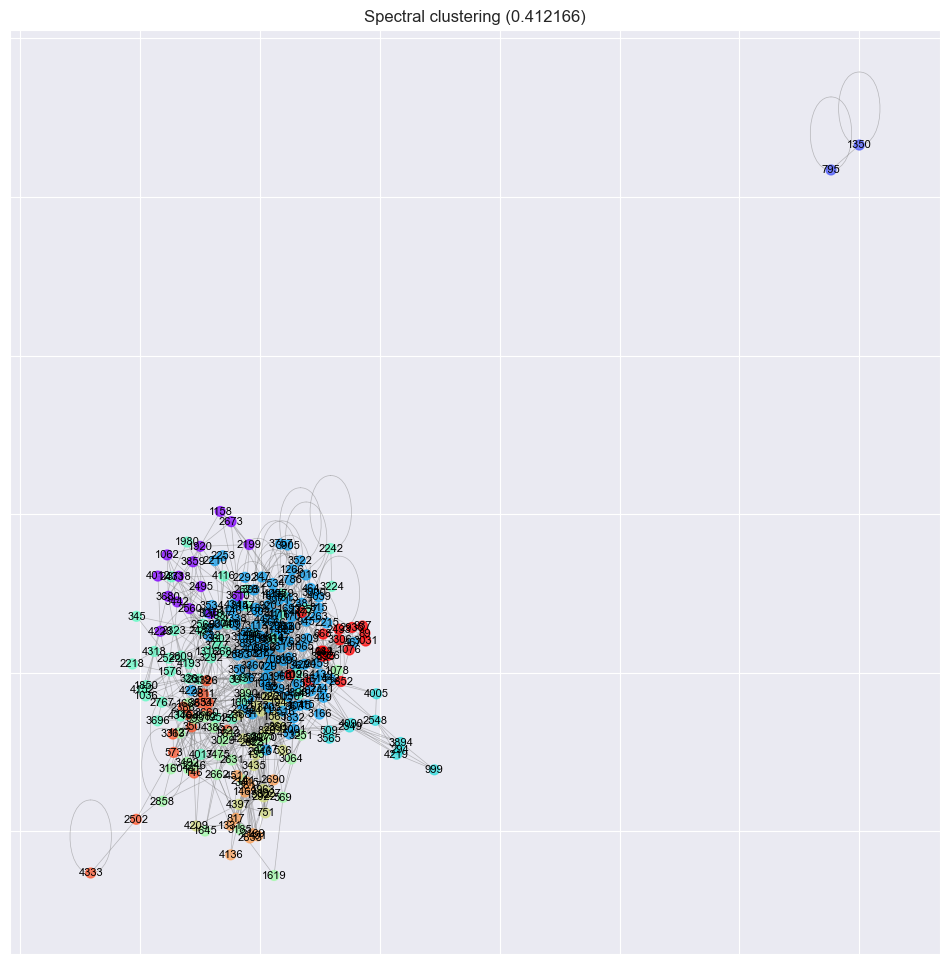

In [98]:
cluster_info = {}
for node, cluster in zip(G.nodes(), labels):
    cluster_info.setdefault(cluster, []).append(G.nodes[node]['label'])

for cluster, keywords in cluster_info.items():
    print(f"Cluster {cluster}: {', '.join(keywords)}")

node_cluster = {node: label for node, label in zip(G.nodes(), labels)}
m = G.size(weight='weight')
degrees = dict(G.degree(weight='weight'))

Q = 0.0
for u, v, data in G.edges(data=True):
    weight = data['weight'] if 'weight' in data else 1
    if node_cluster[u] == node_cluster[v]:
        Q += weight - (degrees[u] * degrees[v]) / (2 * m)

Q /= (2 * m)
clustering = SpectralClustering(n_clusters=10, affinity='precomputed', random_state=42)
labels = clustering.fit_predict(adjacency_matrix)

node_colors = labels
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')
plt.title(f"Spectral clustering ({Q:4f})")
plt.show()

### DBSCAN

In [99]:
G_with_all_links = nx.Graph()

for _, row in filtered_points.iterrows():
    G_with_all_links.add_node(row['id'], label=row['label'], value=row['value'])

for _, row in links_2.iterrows():
    G_with_all_links.add_edge(row['source'], row['target'], weight=row['value'])

G_with_all_links = G_with_all_links.subgraph([node for node in G_with_all_links.nodes() if G_with_all_links.degree(node) >= 2])

adj_matrix = nx.to_numpy_array(G_with_all_links, weight='weight')
cosine_sim = cosine_similarity(adj_matrix)
dist_matrix = np.abs(1 - cosine_sim)

dbscan = DBSCAN(metric="precomputed", eps=0.1, min_samples=5)
labels = dbscan.fit_predict(dist_matrix)


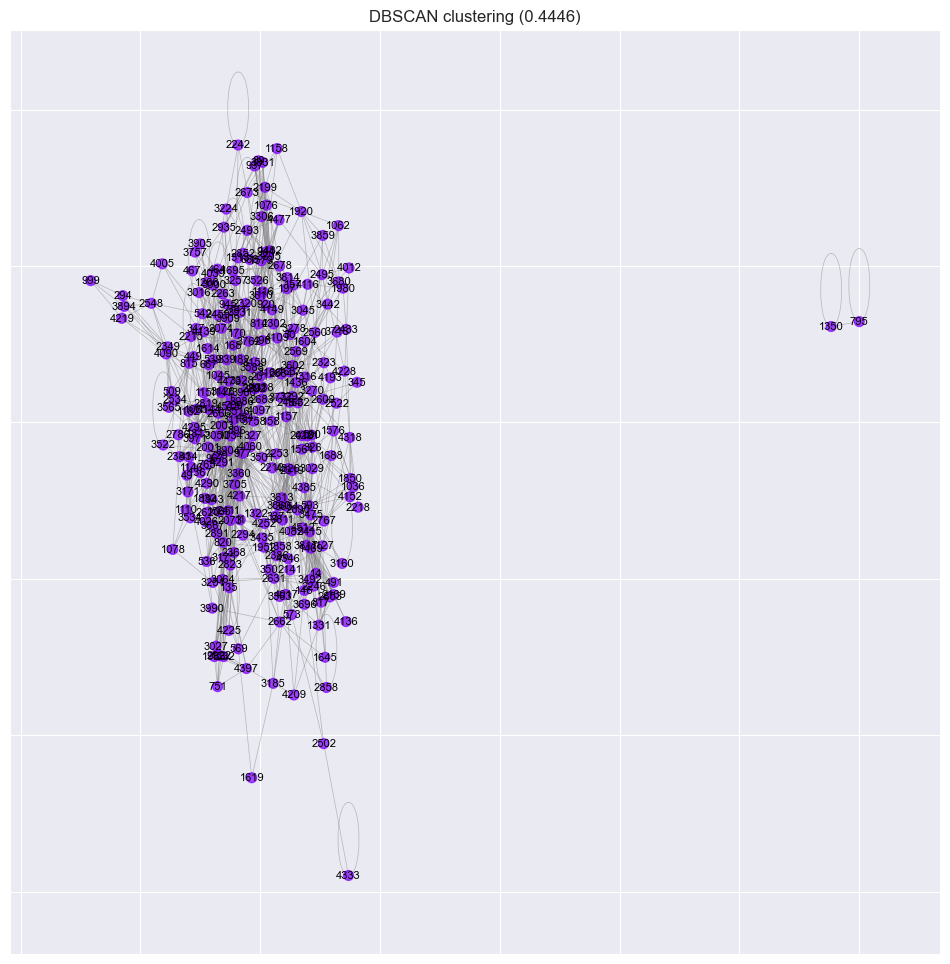

In [107]:
node_colors = labels
m = G_with_all_links.size(weight='weight')
partition = {node: label for node, label in zip(G_with_all_links.nodes(), labels)}
degrees = dict(G_with_all_links.degree(weight='weight'))

Q = 0.0
for u, v, data in G_with_all_links.edges(data=True):
    weight = data['weight'] if 'weight' in data else 1
    if partition[u] == partition[v]:
        expected_weight = (degrees[u] * degrees[v]) / (2 * m)
        Q += weight - expected_weight
Q /= (2 * m)

cluster_info = {}
for node, cluster in zip(G_with_all_links.nodes(), labels):
    cluster_info.setdefault(cluster, []).append(G_with_all_links.nodes[node]['label'])


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_with_all_links)

nx.draw_networkx_nodes(G_with_all_links, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G_with_all_links, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_with_all_links, pos, font_size=8, font_color='black')
plt.title(f"DBSCAN clustering ({Q:.4f})")
plt.show()

---
### 6. Найти ключевые слова с наибольшими значениями центральности в выбранной тематике (например, degree centrality, betweenness centrality, eigenvector centrality, closeness centrality). Интерпретировать результаты.

In [101]:
centralities = {
    "degree": lambda G: nx.degree_centrality(G),
    "betweenness": lambda G: nx.betweenness_centrality(G, weight='weight'),
    "eigenvector": lambda G: nx.eigenvector_centrality(G, weight='weight'),
    "closeness": lambda G: nx.closeness_centrality(G),
}

centralities = {
    key: sorted(f(G).items(), key=lambda x: x[1], reverse=True)[:10]
    for key, f in centralities.items()
}

centralities = {
    key: [f"{G_with_all_links.nodes[node]['label']}: {centrality}" for (node, centrality) in items]
    for key, items in centralities.items()
}

for (key, values) in centralities.items():
    print(key + ":", *values, sep='\n', end='\n\n')

degree:
automata: 0.29213483146067415
language: 0.24719101123595505
word: 0.20599250936329588
regular language: 0.17228464419475656
finite automata: 0.14606741573033707
regular: 0.1348314606741573
finite: 0.12734082397003746
complexity: 0.11235955056179775
system: 0.10861423220973783
problem: 0.10861423220973783

betweenness:
automata: 0.2282601369603381
language: 0.17449279198140408
word: 0.08809454626342424
finite automata: 0.061364654524703396
system: 0.05247561614229508
complexity: 0.05095693582533172
regular language: 0.04616802571357299
temporal logic: 0.04317072625983057
problem: 0.03617608874303725
regular: 0.035790084669718496

eigenvector:
automata: 0.31143152724552275
language: 0.28991161392033776
word: 0.2640816966571893
regular language: 0.24716529393716488
finite: 0.20843529952810375
regular: 0.20578671451748323
finite automata: 0.1848144428356032
infinite word: 0.16172755316190976
infinite: 0.14199646480500694
tree: 0.12764396147903262

closeness:
automata: 0.54118308903

### 1. Degree Centrality
**Keywords**: automata, language, word, regular language, finite automata, regular, finite, complexity, system, problem
- Эти слова встречаются во многих контекстах и тесно связаны с другими терминами. Они формируют ядро предметной области — теория автоматов и формальных языков.

### 2. Betweenness Centrality
**keywords**: automata, language, word, finite automata, system, complexity, regular language, temporal logic, problem, regular
- Слова связывают разные кластеры, выступая "соединителями" между темами. Через них проходят пути между разными семантическими группами.

### 3. Eigenvector Centrality
**keywords**: automata, language, word, regular language, finite, regular, finite automata, infinite word, infinite, tree
- Связаны с ключевыми терминами. Ядро темы составляют automata, language, word - они определяют семантическое ядро графа.

### 4. Closeness Centrality
**keywords**: automata, language, word, finite automata, regular language, regular, system, finite, complexity, stochastic
- Опорные точки, через которые можно быстро «достичь» других ключевых терминов. Это указывает на их структурную значимость в тематике.

---
### 7. Построить граф публикаций: если ключевое слово является тегом для двух публикаций, значит, между ними связь есть. Чем больше общих ключевых слов, тем сильнее связь (выше вес ребра). Реализовать поиск наиболее близких к заданной пользователем публикаций на графе.

In [102]:
G_publications = nx.Graph()

for idx, row in df.iterrows():
    G_publications.add_node(idx, title=row['title'], authors=row['authors'], summary=row['summary'])

for idx, row in df.iterrows():
    keywords = set(row['cleaned_keywords'])

    for other_idx, other_row in df.iterrows():
        if idx == other_idx: continue

        other_keywords = set(other_row['cleaned_keywords'])
        common_keywords = keywords.intersection(other_keywords)
        if common_keywords:
            weight = len(common_keywords)
            G_publications.add_edge(idx, other_idx, weight=weight)


G_publications = G_publications.subgraph([node for node in G_publications.nodes() if G_publications.degree(node) >= 2])

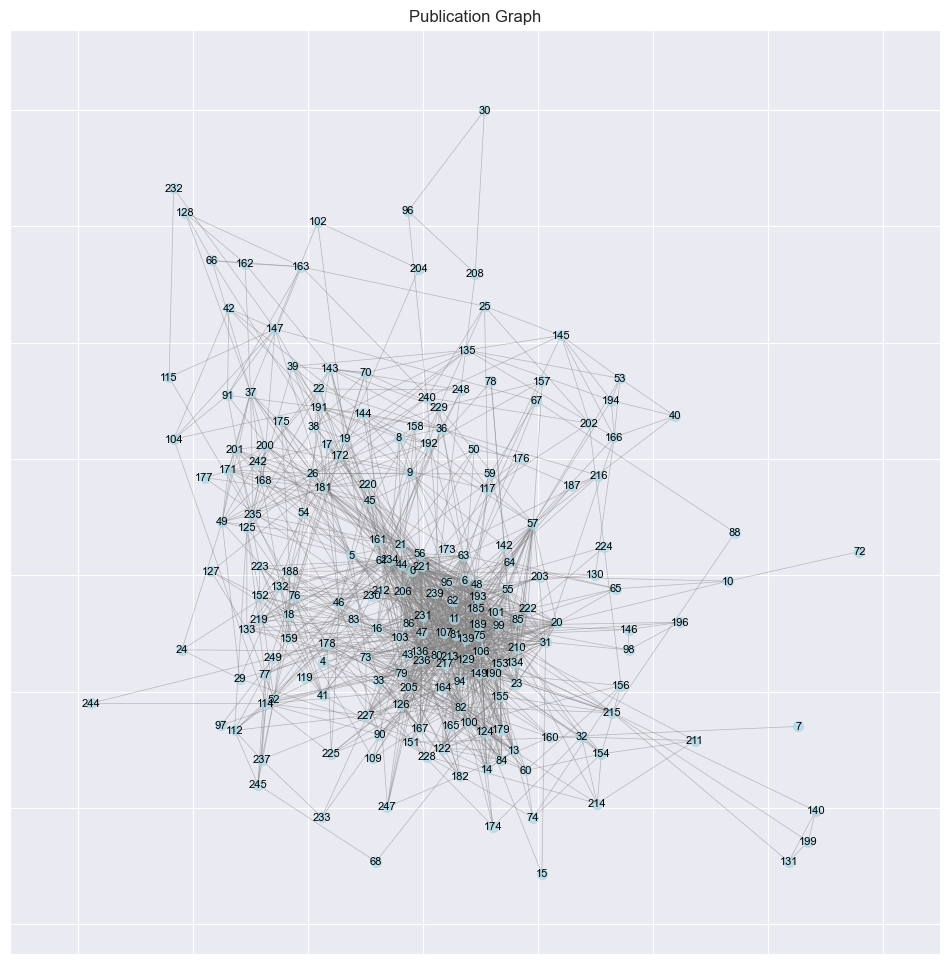

In [103]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_publications, seed=52, k=5, iterations=1000)
nx.draw_networkx_nodes(G_publications, pos, node_size=50, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G_publications, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_publications, pos, font_size=8, font_color='black')
plt.title("Publication Graph")
plt.show()

In [104]:
top_by = dict(
    pagerank = nx.pagerank(G_publications, weight='weight'),
    betweenness = nx.betweenness_centrality(G_publications, weight='weight'),
    degree_centrality = nx.degree_centrality(G_publications)
)

top_by = {
    key: sorted(value.items(), key=lambda x: x[1], reverse=True)[:5]
    for key, value in top_by.items()
}

for (key, values) in top_by.items():
    values = [f"{df.loc[idx, 'title']}: {score}" for idx, score in values]
    print(f"Top 5 {key}:", *values, sep='\n', end='\n\n')

Top 5 pagerank:
Deciding Sparseness of Regular Languages of Finite Trees and Infinite
  Words: 0.015343198281387718
Saturation Problems for Families of Automata: 0.015171296903997204
A Myhill-Nerode Type Characterization of 2detLIN Languages: 0.013369990839049061
On Complementation of Nondeterministic Finite Automata without Full
  Determinization (Technical Report): 0.012948555998818922
How Concise are Chains of co-Büchi Automata?: 0.012124864494118122

Top 5 betweenness:
On Complementation of Nondeterministic Finite Automata without Full
  Determinization (Technical Report): 0.0562127283167623
Addition Automata and Attractors of Digit Systems Corresponding to
  Expanding Rational Matrices: 0.05227184215797389
Componentwise Automata Learning for System Integration (Extended
  Version): 0.05100184315230035
Identifiability and minimality bounds of quantum and post-quantum models
  of classical stochastic processes: 0.046210047352617335
Learning Probabilistic Temporal Logic Specification

In [105]:
targets = {
    target[0][0]: {"by": key, "keywords": df.iloc[target[0][0], :].cleaned_keywords}
    for key, target in top_by.items()
}

for idx, data in targets.items():
    print(f"{idx} (by {data['by']}):", *data['keywords'], sep='\n', end='\n\n')

106 (by pagerank):
regular tree language
regular
regular language finite
infinite word
finite tree infinite
language
tree
infinite word study
language finite tree
infinite
finite tree
regular language
tree infinite word
call sparse
word
finite
study notion
language regular
language finite tree
regular language finite

107 (by betweenness):
equivalent deterministic finite
nondeterministic finite
complementation finite automata
basic operation
operation use numerous
finite automata
automaton
finite automaton
automata without full
technical report
nondeterministic finite automata
finite automata without full
complementation nondeterministic finite
numerous application
equivalent deterministic finite automaton
finite
automata
full determinization
deterministic finite automaton
automata without full determinization

139 (by degree_centrality):
family
represent regular
regular
saturate
fdfa accept pair
define regular
language
component represent period
automata
ultimately periodic
ultimately

In [106]:
for target, data in targets.items():
    print(f"TOP-5 nearest for '{df.loc[target, 'title']}' (id={target}, top-1 by {data['by']}):")

    neighbors = list(G_publications.neighbors(target))
    sorted_neighbors = sorted(neighbors, key=lambda x: G_publications[target][x]['weight'], reverse=True)

    for neighbor in sorted_neighbors[:5]:
        print(f"Publication: {df.loc[neighbor, 'title']}, weight: {G_publications[target][neighbor]['weight']}")

    print()

TOP-5 nearest for 'Deciding Sparseness of Regular Languages of Finite Trees and Infinite
  Words' (id=106, top-1 by pagerank):
Publication: Quantitative Language Automata, weight: 4
Publication: Mapped Exponent and Asymptotic Critical Exponent of Words, weight: 4
Publication: Dynamic Membership for Regular Tree Languages, weight: 4
Publication: Saturation Problems for Families of Automata, weight: 3
Publication: Characterization and Decidability of FC-Definable Regular Languages, weight: 3

TOP-5 nearest for 'On Complementation of Nondeterministic Finite Automata without Full
  Determinization (Technical Report)' (id=107, top-1 by betweenness):
Publication: On Repetitive Finite Automata with Translucent Words, weight: 4
Publication: On some Classes of Reversible 2-head Automata, weight: 3
Publication: Polynomial Complementation of Nondeterministic 2-Way Finite Automata by
  1-Limited Automata, weight: 3
Publication: From regular expressions to deterministic finite automata:
  $2^{\frac